In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

In [1]:
from google.colab import drive
drive.mount("/content/mydrive")

#!unzip /content/mydrive/MyDrive/capstone

Mounted at /content/mydrive


In [ ]:
!pip install torchmetrics

# Importing libraries

In [ ]:
import os
import glob
import time
import torch
import torchvision
import numpy as np
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
# from torchmetrics import JaccardIndex
from torchvision.ops import Conv2dNormActivation
from torch.utils.data import Dataset, DataLoader

import tensorboard
from torch.utils.tensorboard import SummaryWriter

# Dataset Preparation

In [ ]:
class MapillaryDataset(Dataset):
    def __init__(self, root, split="train", transforms=None, limit=None):
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.final_label_ids = [3, 6, 13, 15, 17, 24, 27, 29, 30, 55, 65]


        if not split in ("train", "test", "valid"):
            raise Exception(f"Unknown split: <{split}>, Choose from ('train', 'test', 'valid')")
        else:
            split_map = {"train": "training", "valid": "validation", "test": "testing"}
            self.split = split_map[split]

        self.dataset_path = os.path.join(self.root, self.split)
        self.image_paths = glob.glob(os.path.join(self.dataset_path, "images", "*.jpg"))

        # Limit the number of images if specified
        if limit is not None:
            self.image_paths = self.image_paths[:limit]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path).rstrip("jpg") + "png"
        mask_path = os.path.join(self.dataset_path, "instances", filename)

        image = Image.open(image_path)
        mask_img = Image.open(mask_path)
        mask = self.reduce_mask_classes(np.array(mask_img) // 255)
        mask = torch.Tensor(mask)

        if self.transforms:
            image = self.transforms(image)

        return (image, mask)

    def reduce_mask_classes(self, mask, ignore_idx=0):
        serial_index = 1
        for label_id in range(66):
            if label_id in self.final_label_ids:
                mask[mask == label_id] = serial_index
                serial_index += 1
                continue
            mask[mask == label_id] = ignore_idx

        return mask


# Define the data transforms
data_transforms = transforms.Compose([
    # transforms.Resize([350, 455], interpolation=Image.NEAREST),
    transforms.ToTensor()

  ])

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  dataset_path = "/content/mydrive/MyDrive/capstone_dataset/Dataset"
except:
  IN_COLAB = False
  dataset_path = "capstone/Dataset"

# Usage example
train_dataset = MapillaryDataset(root=dataset_path, split='train', transforms=data_transforms)
valid_dataset = MapillaryDataset(root=dataset_path, split="valid", transforms=data_transforms)
print(len(train_dataset), len(valid_dataset))
img, mask = train_dataset[1]

5001 1999


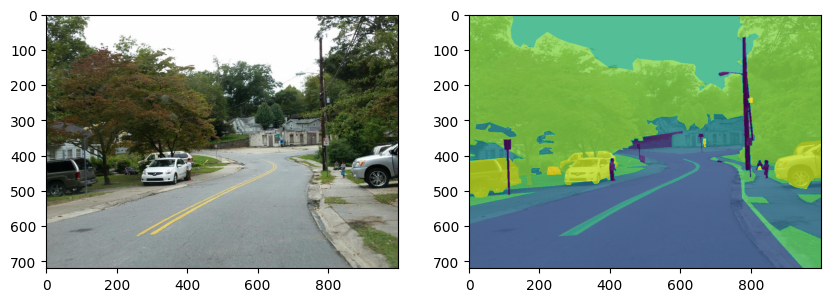

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(122)
plt.imshow(img.permute(1, 2, 0))
plt.imshow(torch.squeeze(mask.permute(0, 1)), alpha=0.8)
plt.show()

In [ ]:
# Define batch size
batch_size = 2
# Create data loader for training dataset
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create validation dataset and data loader
loader_valid = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

print(len(loader_train), len(loader_valid))

2501 1000


# IMAGE vs MASK

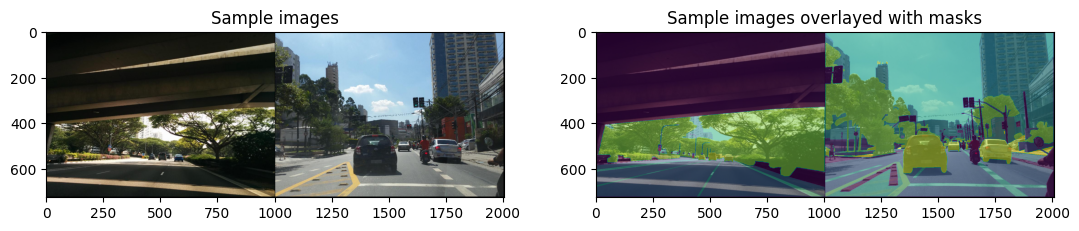

In [ ]:
# Get a batch of images and masks from the training DataLoader
images, masks = next(iter(loader_train))

# Plotting the sample images
plt.figure(figsize=(13, 20))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(images, nrow=2).permute(1, 2, 0))
plt.title("Sample images")

# Plotting the sample images overlayed with masks
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(images, nrow=2).permute(1, 2, 0))
plt.imshow(torchvision.utils.make_grid(torch.unsqueeze(masks, 1), nrow=2).permute(1, 2, 0)[:, :, 0], alpha=0.5)
plt.title("Sample images overlayed with masks")

plt.show()

## Data Modelling

### SegNet


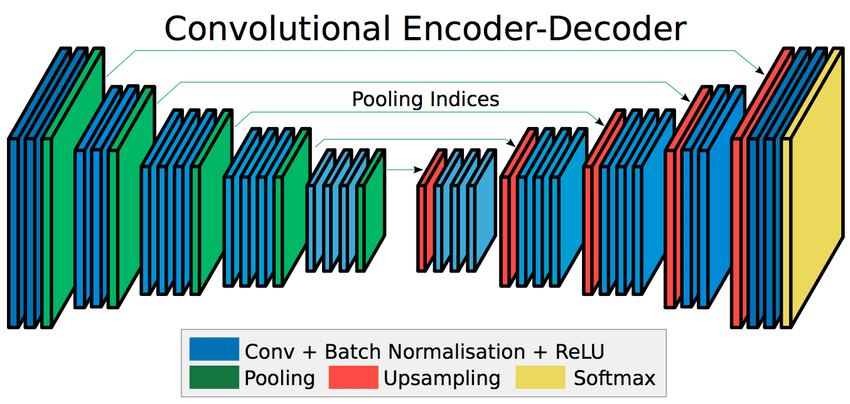

In [ ]:
Image.open("/content/mydrive/MyDrive/capstone_dataset/segnet.png")

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, layers=2, **kwargs):
        super().__init__()
        self.layers = layers
        self.conv1 = Conv2dNormActivation(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            norm_layer=nn.BatchNorm2d,
            activation_layer=nn.LeakyReLU,
            **kwargs
            )
        self.conv2 = Conv2dNormActivation(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            norm_layer=nn.BatchNorm2d,
            activation_layer=nn.LeakyReLU,
            **kwargs
            )

        self.conv3 = Conv2dNormActivation(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            norm_layer=nn.BatchNorm2d,
            activation_layer=nn.LeakyReLU,
            **kwargs
            )

    def forward(self, x):
        x = self.conv2(self.conv1(x))
        if self.layers == 2:
            return x
        return self.conv3(x)


In [ ]:
class SegNet(nn.Module):
    def __init__(self, n_classes=12):
        super().__init__()

        self.enc_conv1 = ConvBlock(in_channels=3, out_channels=64)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv2 = ConvBlock(in_channels=64, out_channels=128)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv3 = ConvBlock(in_channels=128, out_channels=256, layers=3)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv4 = ConvBlock(in_channels=256, out_channels=512, layers=3)
        self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv5 = ConvBlock(in_channels=512, out_channels=1024, layers=3)
        self.mp5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        #### ENCODER | DECODER

        self.upconv5 = nn.MaxUnpool2d( kernel_size=2, stride=2)
        self.dec_conv5 = ConvBlock(in_channels=1024, out_channels=512, layers=3)

        self.upconv4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv4 = ConvBlock(in_channels=512, out_channels=256, layers=3)

        self.upconv3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = ConvBlock(in_channels=256, out_channels=128, layers=3)

        self.upconv2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = ConvBlock(in_channels=128, out_channels=64)

        self.upconv1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = ConvBlock(in_channels=64, out_channels=n_classes)


    def forward(self, x):
        # Encode
        x_ec1 = self.enc_conv1(x)
        shape1 = x_ec1.shape
        x, idx1 = self.mp1(x_ec1)

        x_ec2 = self.enc_conv2(x)
        shape2 = x_ec2.shape
        x, idx2 = self.mp2(x_ec2)

        x_ec3 = self.enc_conv3(x)
        shape3 = x_ec3.shape
        x, idx3 = self.mp3(x_ec3)

        x_ec4 = self.enc_conv4(x)
        shape4 = x_ec4.shape
        x, idx4 = self.mp4(x_ec4)

        x_ec5 = self.enc_conv5(x)
        shape5 = x_ec5.shape
        x, idx5 = self.mp5(x_ec5)

        # Decode
        x = self.upconv5(x, indices=idx5, output_size=shape5)
        x = self.dec_conv5(x)

        x = self.upconv4(x, indices=idx4, output_size=shape4)
        x = self.dec_conv4(x)

        x = self.upconv3(x, indices=idx3, output_size=shape3)
        x = self.dec_conv3(x)

        x = self.upconv2(x, indices=idx2, output_size=shape2)
        x = self.dec_conv2(x)

        x = self.upconv1(x, indices=idx1, output_size=shape1)
        x = self.dec_conv1(x)

        x = nn.Softmax(dim=1)(x)
        return x

### Components

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
segnet_model = SegNet()
segnet_model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-4)
compute_iou = JaccardIndex(num_classes=12, task="multiclass", ignore_index=0).to(device)

#### Verification run

In [ ]:
images = images.to(device)
outputs = segnet_model(images)
outputs.shape

torch.Size([2, 12, 720, 1000])

In [ ]:
masks = masks.to(device)
loss = loss_fn(outputs, masks.long())

In [ ]:
iou_ = compute_iou(outputs.argmax(dim=1), masks)
iou_

tensor(0.0303, device='cuda:0')

In [ ]:
total_loss = loss + iou_
total_loss.backward()

### Main Training - SegNet

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Apr 15 16:04:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0              34W /  70W |    739MiB / 15360MiB |     20%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def train(run_name, save_path, loader_train, loader_valid, model, loss_fn, optimizer, writer, n_epochs=10, patience=5):
    metrics = {"train": {"ce_loss": [], "iou": [], "total": []},
               "valid": {"ce_loss": [], "iou": [], "total": []}}
    counter = 0
    train_iter = 0
    valid_iter = 0

    for epoch in range(1, n_epochs+1):
        # TRAINING
        model.train()
        epoch_ce_loss = []
        epoch_iou = []
        epoch_total = []
        start_time_train = time.time()
        temporary_runtimes_bucket = []
        for batch_num, (images, masks) in enumerate(loader_train):
            start_time = time.time()
            # Transfer images and masks to device
            images = images.to(device)
            masks = masks.to(device)

            # Feed forward, and perform predictions
            outputs = model(images)
            # Compute Cross Entropy Loss and store it
            ce_loss = loss_fn(outputs, masks.long())
            # print(ce_loss.item())
            epoch_ce_loss.append(ce_loss.item())
            # Compute IoU Score and store it
            iou_score = compute_iou(outputs.argmax(dim=1), masks)
            epoch_iou.append(iou_score.item())
            # Compute Total Loss and store it
            total_loss = ce_loss + (1 - iou_score) * 100
            epoch_total.append(total_loss.item())

            # Back propagate gradients
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            end_time = time.time()
            temporary_runtimes_bucket.append(end_time - start_time)
            # For every 10 batches, log metrics
            if batch_num % 10 == 0:
                with writer:
                    writer.add_scalar("train/ce_loss", ce_loss.item(), train_iter)
                    writer.add_scalar("train/iou", iou_score.item(), train_iter)
                    writer.add_scalar("train/total", total_loss.item(), train_iter)
                train_iter += 1
            # For every 100 batches, print status
            if batch_num % 100 == 0 or batch_num == len(loader_train) - 1:
                time_per_batch = np.mean(temporary_runtimes_bucket)
                print(f"[Epoch {epoch:02d}/{n_epochs}] [{batch_num:04d}/{len(loader_train)}] \
CE Loss: {ce_loss.item():.05f} | IoU: {iou_score.item():.05f} | Total Loss: {total_loss.item():.05f} | \
Time per batch: {time_per_batch:0.3f} seconds | Est. time: {(time_per_batch * (len(loader_train) - batch_num)) / 60 :.02f} minutes")
        end_time_train = time.time()
        time_per_train = (end_time_train - start_time_train)
        print(f"Time taken for epoch {epoch:02d}/{n_epochs}: {time_per_train / 60:.02f} minutes")
        print()

        metrics["train"]["ce_loss"].append(np.mean(epoch_ce_loss))
        metrics["train"]["iou"].append(np.mean(epoch_iou))
        metrics["train"]["total"].append(np.mean(epoch_total))

        # VALIDATION
        start_time = time.time()
        model.eval()
        epoch_ce_loss = []
        epoch_iou = []
        epoch_total = []
        for batch_num, (images, masks) in enumerate(loader_valid):
            # Transfer images and masks to device
            images = images.to(device)
            masks = masks.to(device)

            # Feed forward, and perform predictions
            outputs = model(images)
            # Compute Cross Entropy Loss and store it
            ce_loss = loss_fn(outputs, masks.long())
            epoch_ce_loss.append(ce_loss.item())
            # Compute IoU Score and store it
            iou_score = compute_iou(outputs.argmax(dim=1), masks)
            epoch_iou.append(iou_score.item())
            # Compute Total Loss and store it
            total_loss = ce_loss + (1 - iou_score)
            epoch_total.append(total_loss.item())

            if batch_num % 10 == 0:
                with writer:
                    writer.add_scalar("valid/ce_loss", ce_loss.item(), valid_iter)
                    writer.add_scalar("valid/iou", iou_score.item(), valid_iter)
                    writer.add_scalar("valid/total", total_loss.item(), valid_iter)
                valid_iter += 1

        end_time = time.time()
        time_per_validation = (end_time - start_time)
        print(f"[Epoch {epoch:02d}/{n_epochs}] [VALIDATION] CE Loss: {np.mean(epoch_ce_loss):.05f} | IoU: {np.mean(epoch_iou):.05f} | Total Loss: {np.mean(epoch_total):.05f} | Time taken: {time_per_validation / 60:.02f} minutes")
        print()

        metrics["valid"]["ce_loss"].append(np.mean(epoch_ce_loss))
        metrics["valid"]["iou"].append(np.mean(epoch_iou))
        metrics["valid"]["total"].append(np.mean(epoch_total))

        # Early stopping
        if len(metrics["valid"]["total"]) >= 2 and metrics["valid"]["total"][-1] > metrics["valid"]["total"][-2]:
            counter += 1
            print(f"Counter: {counter}")
            if counter == patience:
                print("Early stopping...")
                return metrics
        else:
            counter = 0
            print(f"Saving model and metrics with name: {run_name}")
            model_save_name = f"model_best_{run_name}.pth"
            metrics_save_name = f"metrics_best_{run_name}.pth"
            torch.save(model.state_dict(), os.path.join(save_path, model_save_name))
            torch.save(metrics, os.path.join(save_path, metrics_save_name))

    return metrics



# Saving metrics

In [ ]:
if IN_COLAB:
  model_save_path = "/content/mydrive/MyDrive/capstone_saves/"
else:
  model_save_path = ""
writer = SummaryWriter(log_dir="/content/capstone_logs/")
# segnet_model_save_name = "model_segnet_state_dict.pth"

model_suffix = "segnet"
saved_final_model_path = os.path.join(model_save_path, f"model_final_{model_suffix}.pth")
saved_final_metrics_path = os.path.join(model_save_path, f"metrics_final_{model_suffix}.pth")

saved_best_model_path = os.path.join(model_save_path, f"model_best_{model_suffix}.pth")
saved_best_metrics_path = os.path.join(model_save_path, f"metrics_best_{model_suffix}.pth")

segnet_scores = {}
force_retrain = False

if os.path.exists(saved_final_model_path):
    print("[SegNet] Found existing final model and metrics...")
    print("[SegNet] Loading saved model and metrics...")
    segnet_model.load_state_dict(torch.load(saved_final_model_path, map_location=device))
    segnet_scores = torch.load(saved_final_metrics_path, map_location=device)
    print("[SegNet] Loaded saved model and metrics!")

else:
    if force_retrain == False:
      print("[SegNet] Found existing best model and metrics...")
      print("[SegNet] Loading saved best model and metrics...")
      segnet_model.load_state_dict(torch.load(saved_best_model_path, map_location=device))
      segnet_scores = torch.load(saved_best_metrics_path, map_location=device)
      print("[SegNet] Loaded saved best model and metrics!")
      print("[SegNet] Resuming training...")

    segnet_scores_new = train(
        run_name=model_suffix,
        save_path=model_save_path,
        loader_train=loader_train,
        loader_valid=loader_valid,
        model=segnet_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        writer=writer,
        n_epochs=20,
        patience=3,
        )

    for set_name, set_metrics in segnet_scores_new.items():
      for metric_name, values in set_metrics.items():
        segnet_scores[set_name][metric_name].extend(values)

    final_model_save_path = os.path.join(model_save_path, f"model_final_{model_suffix}.pth")
    final_metrics_save_path = os.path.join(model_save_path, f"metrics_final_{model_suffix}.pth")
    torch.save(segnet_model.state_dict(), final_model_save_path)
    torch.save(segnet_scores, final_metrics_save_path)

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

# Load the model
model = SegNet()  # Replace YourModel with the actual model class you've used
model.load_state_dict(torch.load('/content/mydrive/MyDrive/capstone_saves/model_best_segnet.pth'))
_ = model.eval()


In [ ]:

# Load and preprocess the image
image_path = '/content/mydrive/MyDrive/capstone_dataset/Dataset/training/images/-3bnLdeHkonpmCJj3a1X_w.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the input size of your model
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


In [ ]:
output = model(input_batch)
output.shape

torch.Size([1, 12, 256, 256])

In [ ]:
# Use the model to make predictions
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# Display the result (optional)
import matplotlib.pyplot as plt
plt.imshow(output_predictions.cpu().numpy())
plt.show()

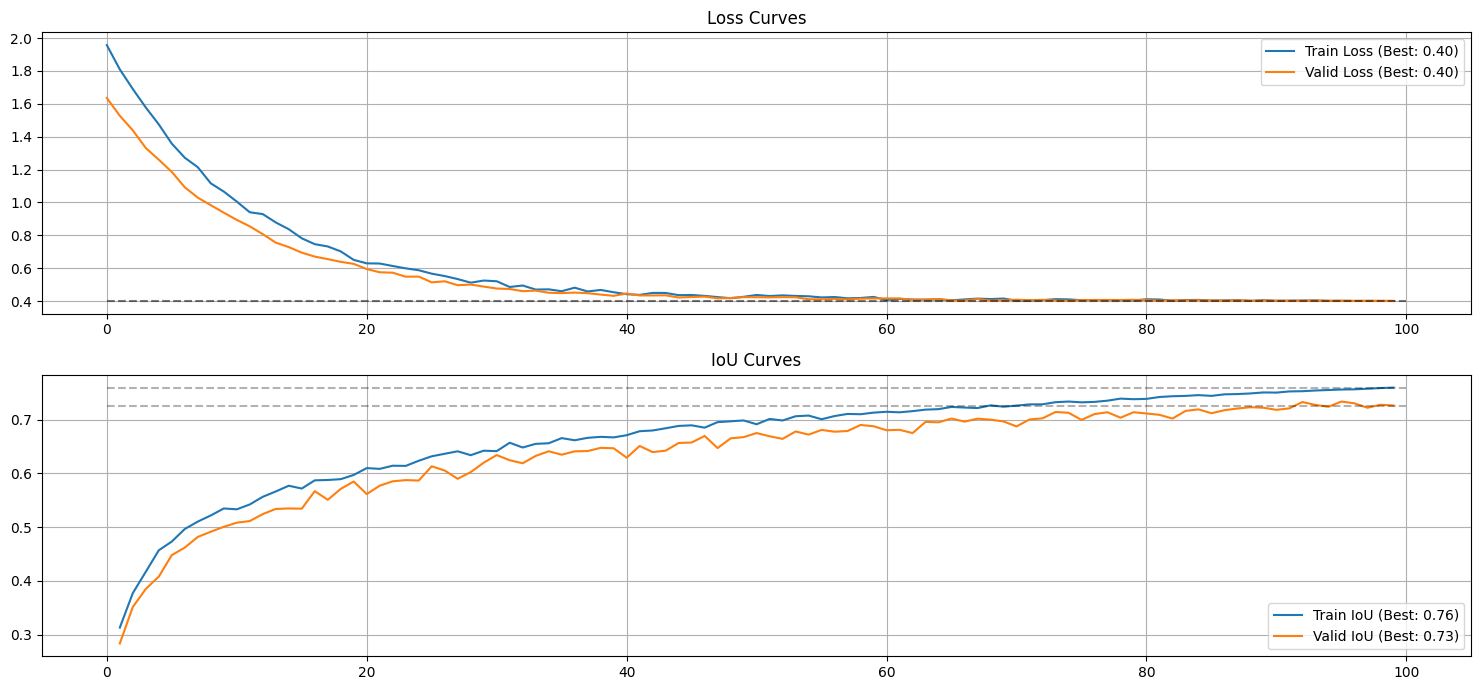

In [8]:
metrics = torch.load("/content/mydrive/MyDrive/capstone_saves/best_metrics.pth")

train_ce_loss, valid_ce_loss = metrics["train_ce_loss"], metrics["valid_ce_loss"]
train_iou, valid_iou = metrics["train_iou"], metrics["valid_iou"]

plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.plot(train_ce_loss, label=f"Train Loss (Best: {train_ce_loss[-1]:.02f})")
plt.plot(valid_ce_loss, label=f"Valid Loss (Best: {valid_ce_loss[-1]:.02f})")
plt.hlines(y=[train_ce_loss[-1], valid_ce_loss[-1]], xmin=0, xmax=len(train_ce_loss), colors="black", linestyle="dashed", alpha=0.3)
plt.legend(loc="upper right")
plt.grid("on")
plt.title("Loss Curves")

plt.subplot(2, 1, 2)
plt.plot(train_iou, label=f"Train IoU (Best: {train_iou[-1]:.02f})")
plt.plot(valid_iou, label=f"Valid IoU (Best: {valid_iou[-1]:.02f})")
plt.hlines(y=[train_iou[-1], valid_iou[-1]], xmin=0, xmax=len(train_iou), colors="black", linestyle="dashed", alpha=0.3)
plt.legend(loc="lower right")
plt.grid("on")
plt.title("IoU Curves")
plt.tight_layout()